In [1]:
import sys
sys.path.append("../")

import torch
import numpy as np
import math
import pickle
import torch.nn as nn
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj, erdos_renyi_graph
from models.GRDPG_GD_Unroll_unshared_normalized import gLASE
from models.rsvd import rsvd
from models.RDPG_GD import GRDPG_GD_Armijo
from models.SVD_truncate import embed_scipy

import matplotlib.pyplot as plt
import seaborn as sns

# Subgraph SBM-2 negative eigenvalues 

Loss GLASE unshared weights (5 layers):  tensor(5171.7695)


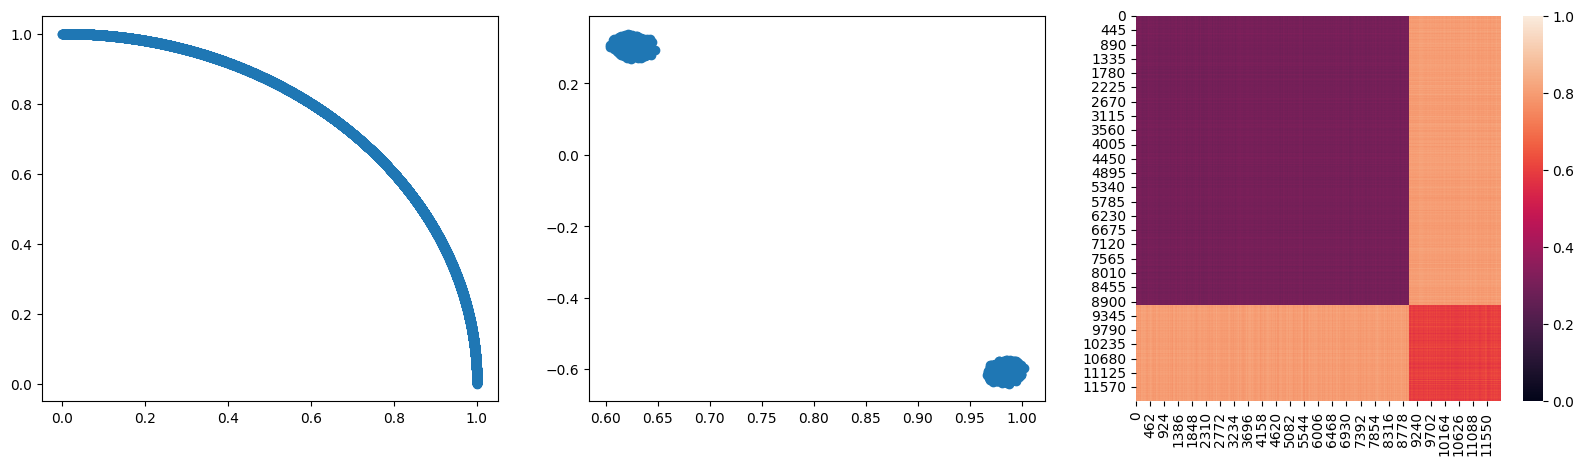

In [3]:
# Load model

d = 2
gd_steps = 5
device = 'cpu'

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load('../saved_models/glase_unshared_d2_normalized_full_negative_phase2_subgraphs_095_unbalanced_complete.pt'))
model.to(device)


# Load original graph

ORIGINAL_GRAPH = '../training/data/sbm2_original_graph_negative_095_unbalanced.pkl'
with open(ORIGINAL_GRAPH, 'rb') as f:
    data= pickle.load(f)

num_nodes = data.num_nodes
edge_index = data.edge_index
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
q = torch.cat((torch.ones(d // 2), -torch.ones(d // 2)))  ## Hay que cambiar por un load
Q = torch.diag(q).detach()

def get_x_init(num_nodes, alpha, beta):
    angles = torch.linspace(alpha, beta, num_nodes)
    x = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)
    return x

x = get_x_init(num_nodes, 0, math.pi/2 ).to(device) 
x_glase = model(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0)))
print(f"Loss GLASE unshared weights ({gd_steps} layers): ", loss)
x_lase = x_glase.to('cpu')

fig, axes = plt.subplots(1, 3, figsize =(20,5))
axes[0].scatter(x[:,0],x[:,1] )
axes[1].scatter(x_glase[:,0],x_glase[:,1] )
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[2], vmin=0.0, vmax=1.0, cbar=True)
plt.show()


# Subgraph SBM-2 positive eigenvalues 

Loss GLASE unshared weights (5 layers):  tensor(4037.4006)


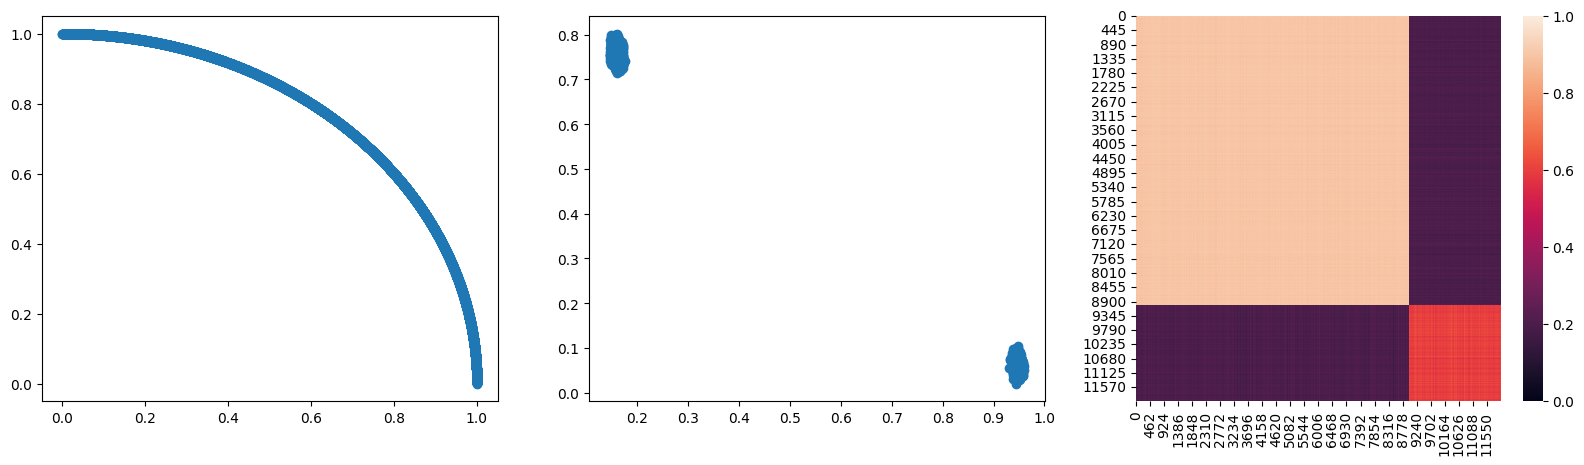

In [2]:
# Load model

d = 2
gd_steps = 5
device = 'cpu'

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load('../saved_models/glase_unshared_d2_normalized_full_positive_subgraphs_095_unbalanced_complete.pt'))
model.to(device)


# Load original graph

ORIGINAL_GRAPH = '../training/data/sbm2_original_graph_positive_095_unbalanced.pkl'
with open(ORIGINAL_GRAPH, 'rb') as f:
    data= pickle.load(f)

num_nodes = data.num_nodes
edge_index = data.edge_index
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
q = torch.cat((torch.ones(d // 2), torch.ones(d // 2)))  ## Hay que cambiar por un load
Q = torch.diag(q).detach()

def get_x_init(num_nodes, alpha, beta):
    angles = torch.linspace(alpha, beta, num_nodes)
    x = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)
    return x

x = get_x_init(num_nodes, 0, math.pi/2 ).to(device) 
x_glase = model(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0)))
print(f"Loss GLASE unshared weights ({gd_steps} layers): ", loss)
x_lase = x_glase.to('cpu')

fig, axes = plt.subplots(1, 3, figsize =(20,5))
axes[0].scatter(x[:,0],x[:,1] )
axes[1].scatter(x_glase[:,0],x_glase[:,1] )
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[2], vmin=0.0, vmax=1.0, cbar=True)
plt.show()


# Subgraph SBM-3 negative eigenvalues 

In [8]:
# Load model

d = 3
gd_steps = 5
device = 'cpu'

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load('../saved_models/glase_unshared_d3_normalized_full_negative_subgraphs_095_unbalanced_complete.pt'))
model.to(device)

def get_x_init_2(num_nodes, alpha, beta, phi_min, phi_max):
    theta = torch.linspace(alpha, beta, num_nodes)  # polar angle
    phi = torch.linspace(phi_min, phi_max, num_nodes)  # azimuthal angle
    r = 1  # assuming a unit sphere, but you could make this an argument if you want

    x = r * torch.sin(theta).unsqueeze(1) * torch.cos(phi).unsqueeze(1)
    y = r * torch.sin(theta).unsqueeze(1) * torch.sin(phi).unsqueeze(1)
    z = r * torch.cos(theta).unsqueeze(1)

    coords = torch.cat((x, y, z), dim=1)  # concatenate along dimension 1 to get [num_nodes, 3] tensor

    return coords


# Load original graph

ORIGINAL_GRAPH = '../training/data/sbm3_unbalanced_negative_original_graph_095.pkl'
with open(ORIGINAL_GRAPH, 'rb') as f:
    data= pickle.load(f)

num_nodes = data.num_nodes
edge_index = data.edge_index
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
q = torch.Tensor([[1,-1,-1]])  ## Hay que cambiar por un load
Q = torch.diag(q[0]).detach()

## GROUND TRUTH
n = [6000, 4000, 2000]
p = [
     [0.6, 0.6, 0.6, 0.9, 0.9, 0.8],
     [0.6, 0.6, 0.6, 0.9, 0.9, 0.8],
     [0.6, 0.6, 0.6, 0.9, 0.9, 0.8],
     [0.9, 0.9, 0.9, 0.3, 0.3, 0.7],
     [0.9, 0.9, 0.9, 0.3, 0.3, 0.7],
     [0.9, 0.9, 0.9, 0.3, 0.3, 0.7],
     [0.8, 0.8, 0.8, 0.7, 0.7, 0.5]
]

x = get_x_init_2(num_nodes, 0, math.pi/2, 0, math.pi/2).to(device)
x_glase = model(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0)))
print(f"Loss GLASE unshared weights ({gd_steps} layers): ", loss)
x_lase = x_glase.to('cpu')

Loss GLASE unshared weights (5 layers):  tensor(4788.1748)


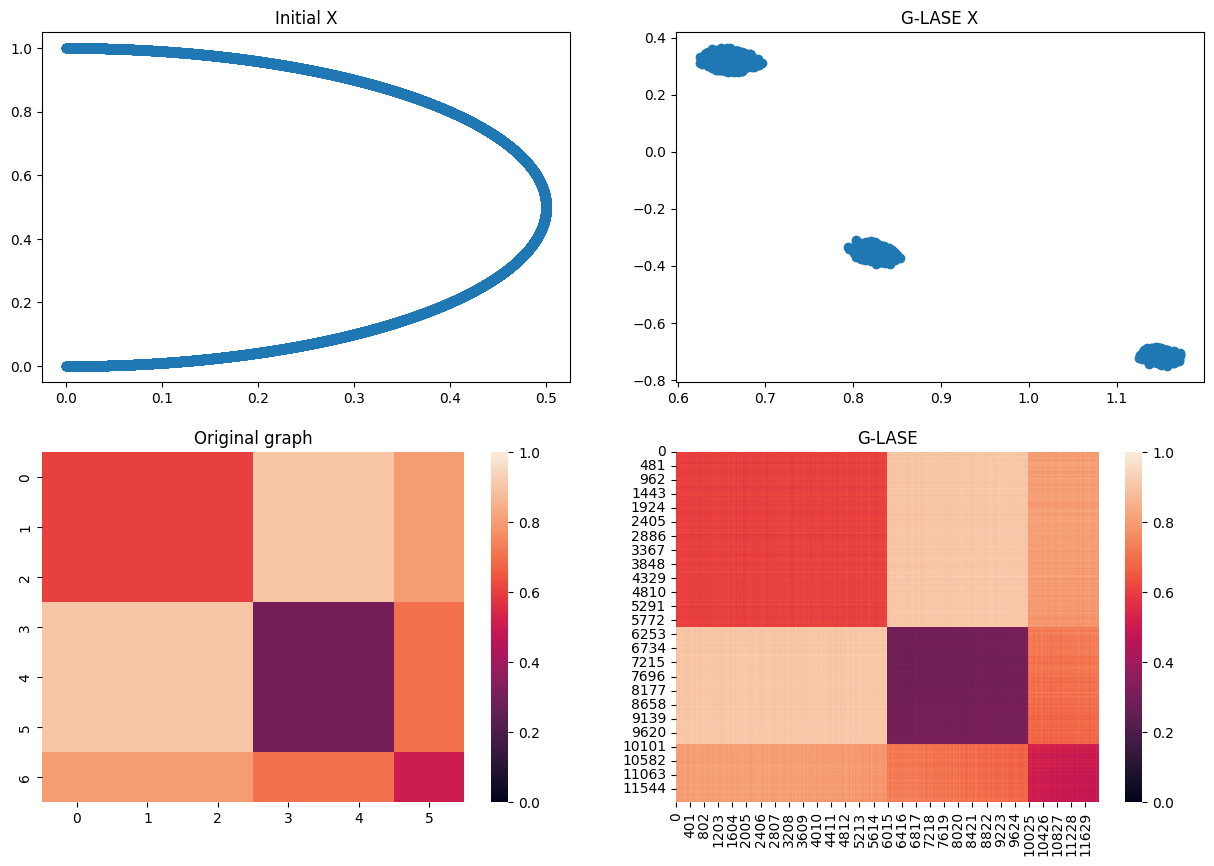

In [15]:
fig, axes = plt.subplots(2, 2, figsize =(15,10))
axes[0,0].scatter(x[:,0],x[:,1])
axes[0,0].set_title('Initial X')
axes[0,1].scatter(x_glase[:,0],x_glase[:,1])
axes[0,1].set_title('G-LASE X')
sns.heatmap(p,ax=axes[1,0], vmin=0,vmax=1, cbar=True)
axes[1,0].set_title('Original graph')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[1,1], vmin=0.0, vmax=1.0, cbar=True)
axes[1,1].set_title('G-LASE')
plt.show()

# Subgraph SBM-3 positive eigenvalues 

In [18]:
# Load model

d = 3
gd_steps = 5
device = 'cpu'

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load('../saved_models/glase_unshared_d3_normalized_full_positive_subgraphs_095_unbalanced_complete.pt'))
model.to(device)

def get_x_init_2(num_nodes, alpha, beta, phi_min, phi_max):
    theta = torch.linspace(alpha, beta, num_nodes)  # polar angle
    phi = torch.linspace(phi_min, phi_max, num_nodes)  # azimuthal angle
    r = 1  # assuming a unit sphere, but you could make this an argument if you want

    x = r * torch.sin(theta).unsqueeze(1) * torch.cos(phi).unsqueeze(1)
    y = r * torch.sin(theta).unsqueeze(1) * torch.sin(phi).unsqueeze(1)
    z = r * torch.cos(theta).unsqueeze(1)

    coords = torch.cat((x, y, z), dim=1)  # concatenate along dimension 1 to get [num_nodes, 3] tensor

    return coords

# Load original graph

ORIGINAL_GRAPH = '../training/data/sbm3_unbalanced_positive_original_graph_095.pkl'
with open(ORIGINAL_GRAPH, 'rb') as f:
    data= pickle.load(f)

num_nodes = data.num_nodes
edge_index = data.edge_index
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
q = torch.Tensor([[1,1,1]])  ## Hay que cambiar por un load
Q = torch.diag(q[0]).detach()

## GROUND TRUTH
p = [
     [0.9, 0.9, 0.9, 0.2, 0.2, 0.1],
     [0.9, 0.9, 0.9, 0.2, 0.2, 0.1],
     [0.9, 0.9, 0.9, 0.2, 0.2, 0.1],
     [0.2, 0.2, 0.2, 0.6, 0.6, 0.2],
     [0.2, 0.2, 0.2, 0.6, 0.6, 0.2],
     [0.1, 0.1, 0.1, 0.2, 0.2, 0.7]
]
x = get_x_init_2(num_nodes, 0, math.pi/2, 0, math.pi/2).to(device)
x_glase = model(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0)))
print(f"Loss GLASE unshared weights ({gd_steps} layers): ", loss)
x_lase = x_glase.to('cpu')

Loss GLASE unshared weights (5 layers):  tensor(4293.1372)


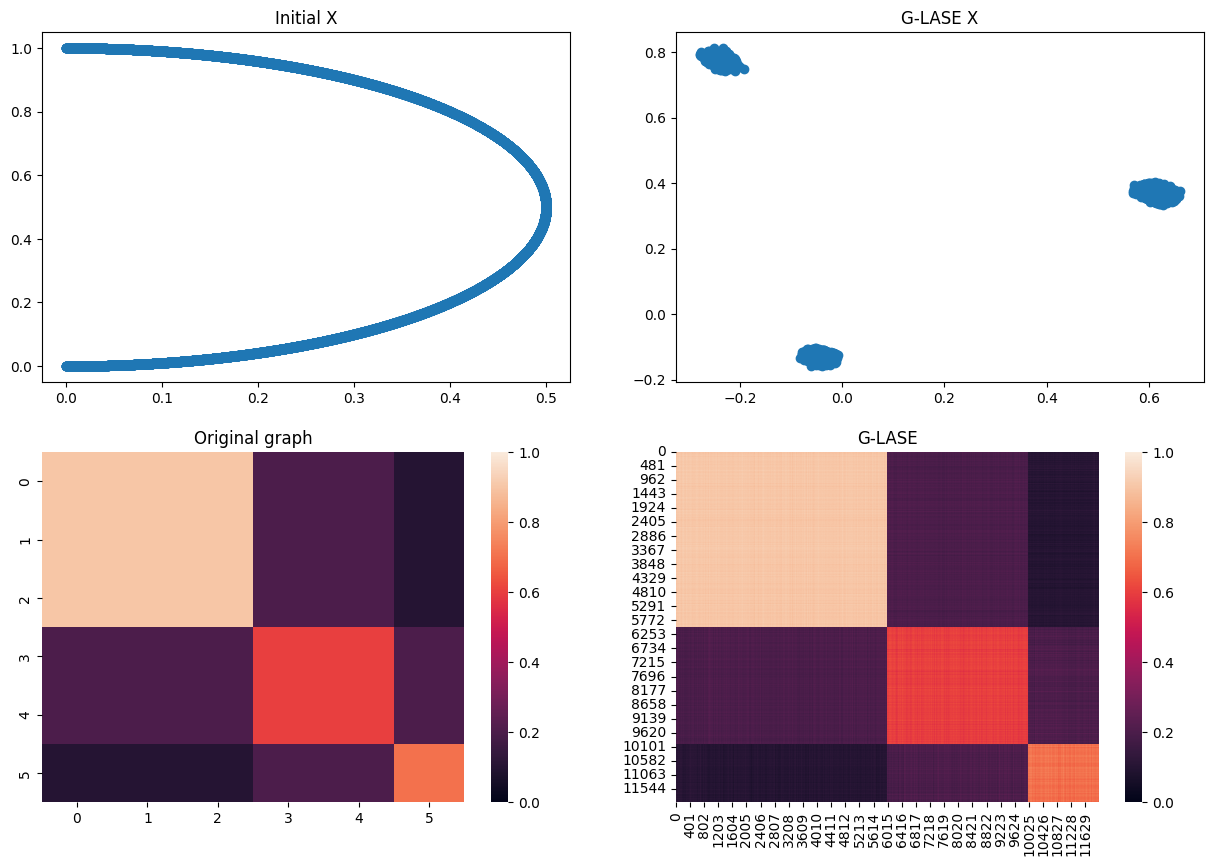

In [19]:
fig, axes = plt.subplots(2, 2, figsize =(15,10))
axes[0,0].scatter(x[:,0],x[:,1])
axes[0,0].set_title('Initial X')
axes[0,1].scatter(x_glase[:,0],x_glase[:,1])
axes[0,1].set_title('G-LASE X')
sns.heatmap(p,ax=axes[1,0], vmin=0,vmax=1, cbar=True)
axes[1,0].set_title('Original graph')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[1,1], vmin=0.0, vmax=1.0, cbar=True)
axes[1,1].set_title('G-LASE')
plt.show()

# SBM-5 negative eigenvalues 

Loss GLASE unshared weights (5 layers):  tensor(1369.2498)


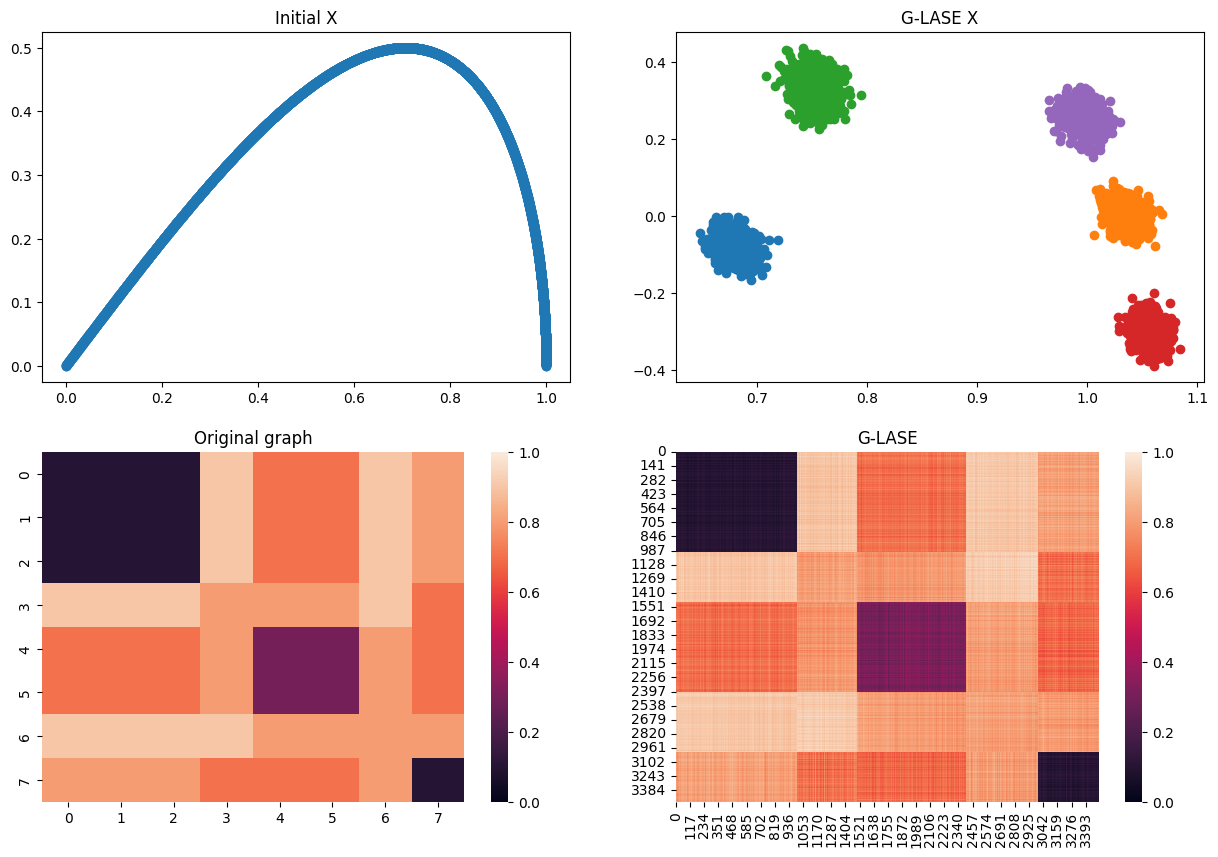

In [9]:
# Load model

d = 5
gd_steps = 5
device = 'cpu'

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load('../saved_models/glase_unshared_d5_normalized_full_negative_phase2.pt'))
model.to(device)

def get_x_init(num_nodes, alpha, beta, phi_min, phi_max):
    dim = 5  # target dimensionality
    r = 1  # assuming a unit hypersphere
    
    # Generate num_nodes angles for each dimension, within specified ranges
    angles = [torch.linspace(phi_min, phi_max, num_nodes) for _ in range(dim - 1)]
    angles.insert(0, torch.linspace(alpha, beta, num_nodes))  # Insert theta angles at the beginning
    
    coords = torch.zeros((num_nodes, dim))
    
    # Compute coordinates in a loop
    for i in range(dim):
        coord = r
        for j in range(i):
            coord *= torch.sin(angles[j])
        if i < dim - 1:
            coord *= torch.cos(angles[i])
        coords[:, i] = coord
        
    return coords


## GROUND TRUTH
p_orig = [
    [0.1, 0.1, 0.1, 0.9, 0.7, 0.7, 0.9, 0.8],
    [0.1, 0.1, 0.1, 0.9, 0.7, 0.7, 0.9, 0.8],
    [0.1, 0.1, 0.1, 0.9, 0.7, 0.7, 0.9, 0.8],
    [0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.9, 0.7],
    [0.7, 0.7, 0.7, 0.8, 0.3, 0.3, 0.8, 0.7],
    [0.7, 0.7, 0.7, 0.8, 0.3, 0.3, 0.8, 0.7],
    [0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8],
    [0.8, 0.8, 0.8, 0.7, 0.7, 0.7, 0.8, 0.1],
]
n = [1000, 500, 900, 600, 500]
p = [
    [0.1, 0.9, 0.7, 0.9, 0.8],
    [0.9, 0.8, 0.8, 0.9, 0.7],
    [0.7, 0.8, 0.3, 0.8, 0.7],
    [0.9, 0.9, 0.8, 0.8, 0.8],
    [0.8, 0.7, 0.7, 0.8, 0.1],
]

num_nodes = 3500
edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
q = torch.Tensor([[1,-1,-1,-1,-1]])  ## Hay que cambiar por un load
Q = torch.diag(q[0]).detach()


x = get_x_init(num_nodes, 0, math.pi/2, 0, math.pi/2).to(device)
x_glase = model(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss GLASE unshared weights ({gd_steps} layers): ", loss)
x_lase = x_glase.to('cpu')

fig, axes = plt.subplots(2, 2, figsize =(15,10))
axes[0,0].scatter(x[:,0],x[:,1])
axes[0,0].set_title('Initial X')
axes[0,1].scatter(x_glase[:1000,0],x_glase[:1000,1])
axes[0,1].scatter(x_glase[1000:1500,0],x_glase[1000:1500,1])
axes[0,1].scatter(x_glase[1500:2400,0],x_glase[1500:2400,1])
axes[0,1].scatter(x_glase[2400:3000,0],x_glase[2400:3000,1])
axes[0,1].scatter(x_glase[3000:,0],x_glase[3000:,1])
axes[0,1].set_title('G-LASE X')
sns.heatmap(p_orig,ax=axes[1,0], vmin=0,vmax=1, cbar=True)
axes[1,0].set_title('Original graph')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[1,1], vmin=0.0, vmax=1.0, cbar=True)
axes[1,1].set_title('G-LASE')
plt.show()

# SBM-10 negative eigenvalues 

Loss GLASE unshared weights (10 layers):  tensor(1617.7432)


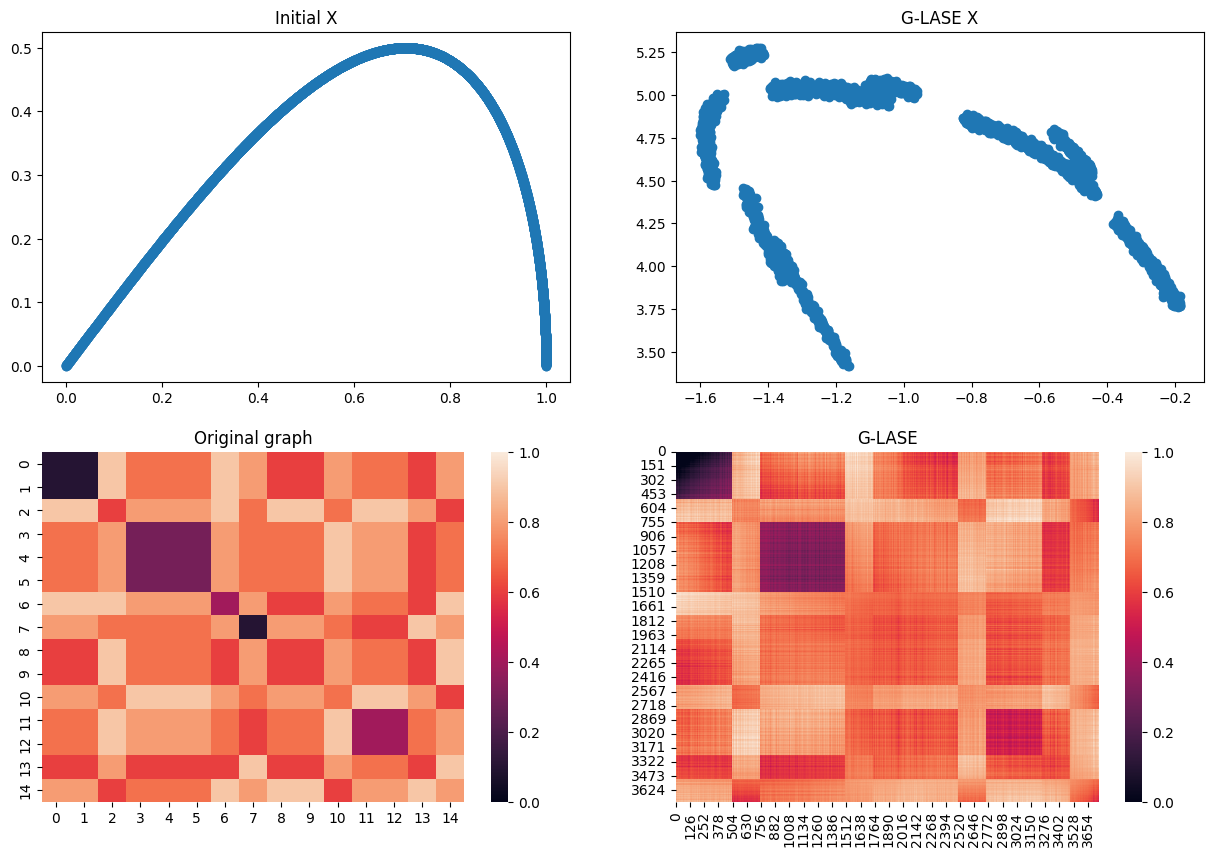

In [2]:
# Load model

d = 10
gd_steps = 10
device = 'cpu'

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load('../saved_models/glase_unshared_d10_normalized_full_negative_phase2.pt'))
model.to(device)

def get_x_init(num_nodes, alpha, beta, phi_min, phi_max):
    dim = 10  # target dimensionality
    r = 1  # assuming a unit hypersphere
    
    # Generate num_nodes angles for each dimension, within specified ranges
    angles = [torch.linspace(phi_min, phi_max, num_nodes) for _ in range(dim - 1)]
    angles.insert(0, torch.linspace(alpha, beta, num_nodes))  # Insert theta angles at the beginning
    
    coords = torch.zeros((num_nodes, dim))
    
    # Compute coordinates in a loop
    for i in range(dim):
        coord = r
        for j in range(i):
            coord *= torch.sin(angles[j])
        if i < dim - 1:
            coord *= torch.cos(angles[i])
        coords[:, i] = coord
        
    return coords


## GROUND TRUTH
p_orig = [
    [0.1, 0.1, 0.9, 0.7, 0.7, 0.7, 0.9, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.8],
    [0.1, 0.1, 0.9, 0.7, 0.7, 0.7, 0.9, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.8],    
    [0.9, 0.9, 0.6, 0.8, 0.8, 0.8, 0.9, 0.7, 0.9, 0.9, 0.7, 0.9, 0.9, 0.8, 0.6],
    [0.7, 0.7, 0.8, 0.3, 0.3, 0.3, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.8, 0.6, 0.7],
    [0.7, 0.7, 0.8, 0.3, 0.3, 0.3, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.8, 0.6, 0.7],
    [0.7, 0.7, 0.8, 0.3, 0.3, 0.3, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.8, 0.6, 0.7],        
    [0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.4, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.9],
    [0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.8, 0.1, 0.8, 0.8, 0.7, 0.6, 0.6, 0.9, 0.8],
    [0.6, 0.6, 0.9, 0.7, 0.7, 0.7, 0.6, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.9],
    [0.6, 0.6, 0.9, 0.7, 0.7, 0.7, 0.6, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.9],    
    [0.8, 0.8, 0.7, 0.9, 0.9, 0.9, 0.8, 0.7, 0.8, 0.8, 0.7, 0.9, 0.9, 0.8, 0.6],
    [0.7, 0.7, 0.9, 0.8, 0.8, 0.8, 0.7, 0.6, 0.7, 0.7, 0.9, 0.4, 0.4, 0.7, 0.8],
    [0.7, 0.7, 0.9, 0.8, 0.8, 0.8, 0.7, 0.6, 0.7, 0.7, 0.9, 0.4, 0.4, 0.7, 0.8],
    [0.6, 0.6, 0.8, 0.6, 0.6, 0.6, 0.6, 0.9, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.9],
    [0.8, 0.8, 0.6, 0.7, 0.7, 0.7, 0.9, 0.8, 0.9, 0.9, 0.6, 0.8, 0.8, 0.9, 0.8], 
]
n = [500, 250, 750, 250, 250, 500, 250, 500, 250, 250]

p = [
    [0.1, 0.9, 0.7, 0.9, 0.8, 0.6, 0.8, 0.7, 0.6, 0.8],
    [0.9, 0.6, 0.8, 0.9, 0.7, 0.9, 0.7, 0.9, 0.8, 0.6],
    [0.7, 0.8, 0.3, 0.8, 0.7, 0.7, 0.9, 0.8, 0.6, 0.7],
    [0.9, 0.9, 0.8, 0.4, 0.8, 0.6, 0.8, 0.7, 0.6, 0.9],
    [0.8, 0.7, 0.7, 0.8, 0.1, 0.8, 0.7, 0.6, 0.9, 0.8],
    [0.6, 0.9, 0.7, 0.6, 0.8, 0.6, 0.8, 0.7, 0.6, 0.9],
    [0.8, 0.7, 0.9, 0.8, 0.7, 0.8, 0.7, 0.9, 0.8, 0.6],
    [0.7, 0.9, 0.8, 0.7, 0.6, 0.7, 0.9, 0.4, 0.7, 0.8],
    [0.6, 0.8, 0.6, 0.6, 0.9, 0.6, 0.8, 0.7, 0.6, 0.9],
    [0.8, 0.6, 0.7, 0.9, 0.8, 0.9, 0.6, 0.8, 0.9, 0.8], 
]

num_nodes = 3750
edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
q = torch.Tensor([[1,1,1,-1,-1,-1,-1,-1,-1,-1]]) ## Hay que cambiar por un load
Q = torch.diag(q[0]).detach()


x = get_x_init(num_nodes, 0, math.pi/2, 0, math.pi/2).to(device)
x_glase = model(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss GLASE unshared weights ({gd_steps} layers): ", loss)
x_lase = x_glase.to('cpu')

fig, axes = plt.subplots(2, 2, figsize =(15,10))
axes[0,0].scatter(x[:,0],x[:,1])
axes[0,0].set_title('Initial X')
axes[0,1].scatter(x_glase[:,0],x_glase[:,1])
axes[0,1].set_title('G-LASE X')
sns.heatmap(p_orig,ax=axes[1,0], vmin=0,vmax=1, cbar=True)
axes[1,0].set_title('Original graph')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[1,1], vmin=0.0, vmax=1.0, cbar=True)
axes[1,1].set_title('G-LASE')
plt.show()

Loss GLASE unshared weights (5 layers):  tensor(1616.8082)


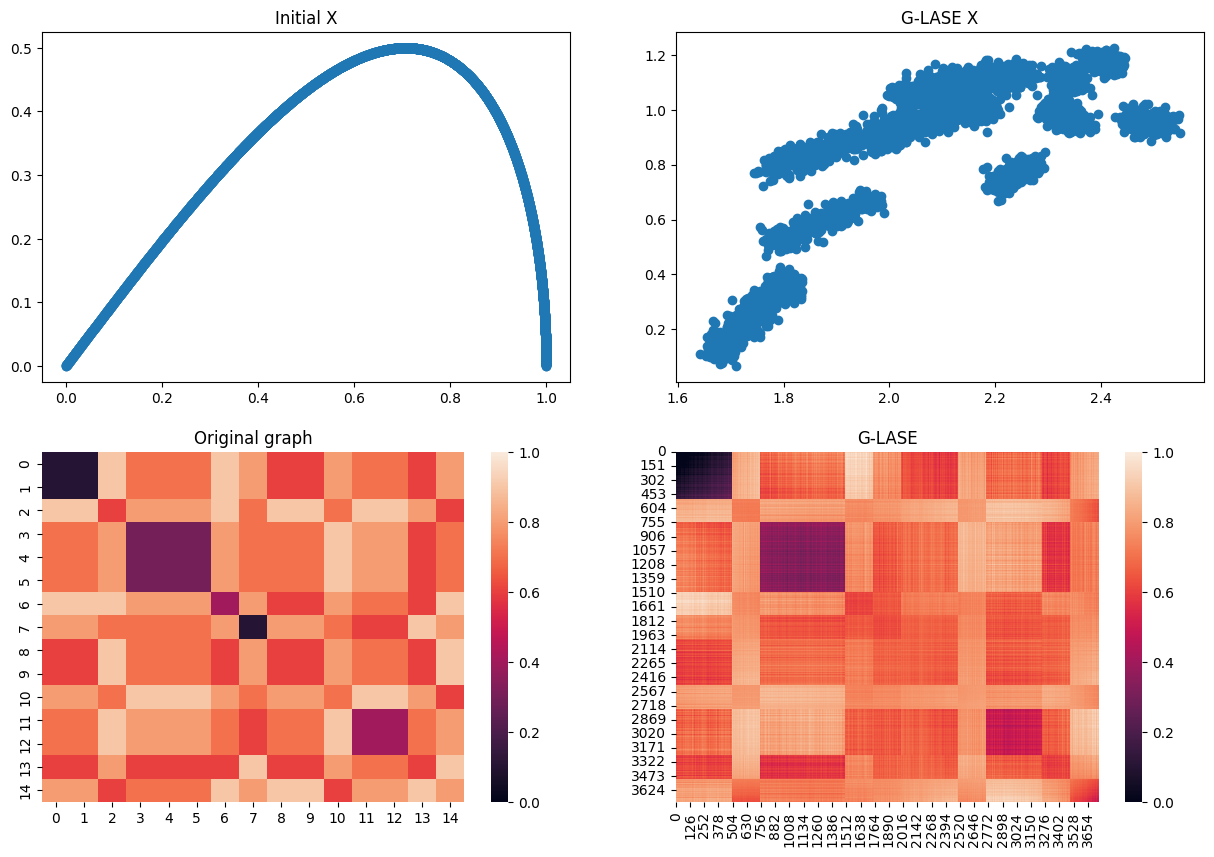

In [5]:
# Load model

d = 5
gd_steps = 5
device = 'cpu'

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load('../saved_models/glase_unshared_d5_normalized_full_negative_phase2_sbm10.pt'))
model.to(device)

def get_x_init(num_nodes, alpha, beta, phi_min, phi_max):
    dim = 5  # target dimensionality
    r = 1  # assuming a unit hypersphere
    
    # Generate num_nodes angles for each dimension, within specified ranges
    angles = [torch.linspace(phi_min, phi_max, num_nodes) for _ in range(dim - 1)]
    angles.insert(0, torch.linspace(alpha, beta, num_nodes))  # Insert theta angles at the beginning
    
    coords = torch.zeros((num_nodes, dim))
    
    # Compute coordinates in a loop
    for i in range(dim):
        coord = r
        for j in range(i):
            coord *= torch.sin(angles[j])
        if i < dim - 1:
            coord *= torch.cos(angles[i])
        coords[:, i] = coord
        
    return coords


## GROUND TRUTH
p_orig = [
    [0.1, 0.1, 0.9, 0.7, 0.7, 0.7, 0.9, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.8],
    [0.1, 0.1, 0.9, 0.7, 0.7, 0.7, 0.9, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.8],    
    [0.9, 0.9, 0.6, 0.8, 0.8, 0.8, 0.9, 0.7, 0.9, 0.9, 0.7, 0.9, 0.9, 0.8, 0.6],
    [0.7, 0.7, 0.8, 0.3, 0.3, 0.3, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.8, 0.6, 0.7],
    [0.7, 0.7, 0.8, 0.3, 0.3, 0.3, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.8, 0.6, 0.7],
    [0.7, 0.7, 0.8, 0.3, 0.3, 0.3, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.8, 0.6, 0.7],        
    [0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.4, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.9],
    [0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.8, 0.1, 0.8, 0.8, 0.7, 0.6, 0.6, 0.9, 0.8],
    [0.6, 0.6, 0.9, 0.7, 0.7, 0.7, 0.6, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.9],
    [0.6, 0.6, 0.9, 0.7, 0.7, 0.7, 0.6, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.9],    
    [0.8, 0.8, 0.7, 0.9, 0.9, 0.9, 0.8, 0.7, 0.8, 0.8, 0.7, 0.9, 0.9, 0.8, 0.6],
    [0.7, 0.7, 0.9, 0.8, 0.8, 0.8, 0.7, 0.6, 0.7, 0.7, 0.9, 0.4, 0.4, 0.7, 0.8],
    [0.7, 0.7, 0.9, 0.8, 0.8, 0.8, 0.7, 0.6, 0.7, 0.7, 0.9, 0.4, 0.4, 0.7, 0.8],
    [0.6, 0.6, 0.8, 0.6, 0.6, 0.6, 0.6, 0.9, 0.6, 0.6, 0.8, 0.7, 0.7, 0.6, 0.9],
    [0.8, 0.8, 0.6, 0.7, 0.7, 0.7, 0.9, 0.8, 0.9, 0.9, 0.6, 0.8, 0.8, 0.9, 0.8], 
]
n = [500, 250, 750, 250, 250, 500, 250, 500, 250, 250]

p = [
    [0.1, 0.9, 0.7, 0.9, 0.8, 0.6, 0.8, 0.7, 0.6, 0.8],
    [0.9, 0.6, 0.8, 0.9, 0.7, 0.9, 0.7, 0.9, 0.8, 0.6],
    [0.7, 0.8, 0.3, 0.8, 0.7, 0.7, 0.9, 0.8, 0.6, 0.7],
    [0.9, 0.9, 0.8, 0.4, 0.8, 0.6, 0.8, 0.7, 0.6, 0.9],
    [0.8, 0.7, 0.7, 0.8, 0.1, 0.8, 0.7, 0.6, 0.9, 0.8],
    [0.6, 0.9, 0.7, 0.6, 0.8, 0.6, 0.8, 0.7, 0.6, 0.9],
    [0.8, 0.7, 0.9, 0.8, 0.7, 0.8, 0.7, 0.9, 0.8, 0.6],
    [0.7, 0.9, 0.8, 0.7, 0.6, 0.7, 0.9, 0.4, 0.7, 0.8],
    [0.6, 0.8, 0.6, 0.6, 0.9, 0.6, 0.8, 0.7, 0.6, 0.9],
    [0.8, 0.6, 0.7, 0.9, 0.8, 0.9, 0.6, 0.8, 0.9, 0.8], 
]

num_nodes = 3750
edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
q = torch.Tensor([[1,-1,-1,-1,-1]])
Q = torch.diag(q[0]).detach()


x = get_x_init(num_nodes, 0, math.pi/2, 0, math.pi/2).to(device)
x_glase = model(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss GLASE unshared weights ({gd_steps} layers): ", loss)
x_lase = x_glase.to('cpu')

fig, axes = plt.subplots(2, 2, figsize =(15,10))
axes[0,0].scatter(x[:,0],x[:,1])
axes[0,0].set_title('Initial X')
axes[0,1].scatter(x_glase[:,0],x_glase[:,1])
axes[0,1].set_title('G-LASE X')
sns.heatmap(p_orig,ax=axes[1,0], vmin=0,vmax=1, cbar=True)
axes[1,0].set_title('Original graph')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[1,1], vmin=0.0, vmax=1.0, cbar=True)
axes[1,1].set_title('G-LASE')
plt.show()

# SBM-8 negative eigenvalues 

Loss GLASE unshared weights (5 layers):  tensor(1386.2644)


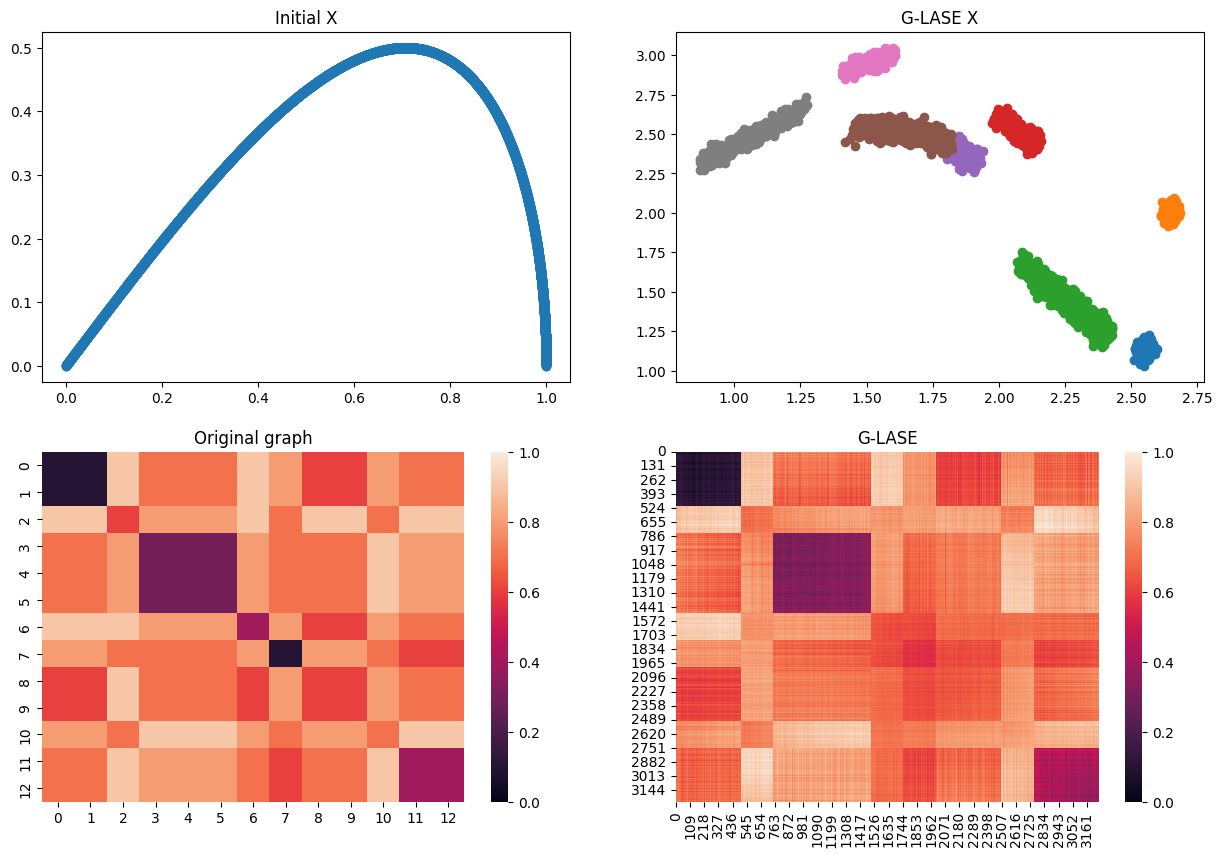

In [12]:
# Load model

d = 8
gd_steps = 5
device = 'cpu'

model = gLASE(d,d, gd_steps)
model.load_state_dict(torch.load('../saved_models/glase_unshared_d8_normalized_full_negative_phase2.pt'))
model.to(device)

def get_x_init(num_nodes, alpha, beta, phi_min, phi_max):
    dim = 8  # target dimensionality
    r = 1  # assuming a unit hypersphere
    
    # Generate num_nodes angles for each dimension, within specified ranges
    angles = [torch.linspace(phi_min, phi_max, num_nodes) for _ in range(dim - 1)]
    angles.insert(0, torch.linspace(alpha, beta, num_nodes))  # Insert theta angles at the beginning
    
    coords = torch.zeros((num_nodes, dim))
    
    # Compute coordinates in a loop
    for i in range(dim):
        coord = r
        for j in range(i):
            coord *= torch.sin(angles[j])
        if i < dim - 1:
            coord *= torch.cos(angles[i])
        coords[:, i] = coord
        
    return coords


## GROUND TRUTH
p_orig = [
    [0.1, 0.1, 0.9, 0.7, 0.7, 0.7, 0.9, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7],
    [0.1, 0.1, 0.9, 0.7, 0.7, 0.7, 0.9, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7],    
    [0.9, 0.9, 0.6, 0.8, 0.8, 0.8, 0.9, 0.7, 0.9, 0.9, 0.7, 0.9, 0.9],
    [0.7, 0.7, 0.8, 0.3, 0.3, 0.3, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.8],
    [0.7, 0.7, 0.8, 0.3, 0.3, 0.3, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.8],
    [0.7, 0.7, 0.8, 0.3, 0.3, 0.3, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.8],        
    [0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.4, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7],
    [0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.8, 0.1, 0.8, 0.8, 0.7, 0.6, 0.6],
    [0.6, 0.6, 0.9, 0.7, 0.7, 0.7, 0.6, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7],
    [0.6, 0.6, 0.9, 0.7, 0.7, 0.7, 0.6, 0.8, 0.6, 0.6, 0.8, 0.7, 0.7],    
    [0.8, 0.8, 0.7, 0.9, 0.9, 0.9, 0.8, 0.7, 0.8, 0.8, 0.7, 0.9, 0.9],
    [0.7, 0.7, 0.9, 0.8, 0.8, 0.8, 0.7, 0.6, 0.7, 0.7, 0.9, 0.4, 0.4],
    [0.7, 0.7, 0.9, 0.8, 0.8, 0.8, 0.7, 0.6, 0.7, 0.7, 0.9, 0.4, 0.4],
]
n = [500, 250, 750, 250, 250, 500, 250, 500]

p = [
    [0.1, 0.9, 0.7, 0.9, 0.8, 0.6, 0.8, 0.7],
    [0.9, 0.6, 0.8, 0.9, 0.7, 0.9, 0.7, 0.9],
    [0.7, 0.8, 0.3, 0.8, 0.7, 0.7, 0.9, 0.8],
    [0.9, 0.9, 0.8, 0.4, 0.8, 0.6, 0.8, 0.7],
    [0.8, 0.7, 0.7, 0.8, 0.1, 0.8, 0.7, 0.6],
    [0.6, 0.9, 0.7, 0.6, 0.8, 0.6, 0.8, 0.7],
    [0.8, 0.7, 0.9, 0.8, 0.7, 0.8, 0.7, 0.9],
    [0.7, 0.9, 0.8, 0.7, 0.6, 0.7, 0.9, 0.4],
]

num_nodes = 3250
edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
q = torch.Tensor([[1,1,-1,-1,-1,-1,-1,-1]])
Q = torch.diag(q[0]).detach()


x = get_x_init(num_nodes, 0, math.pi/2, 0, math.pi/2).to(device)
x_glase = model(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss GLASE unshared weights ({gd_steps} layers): ", loss)
x_lase = x_glase.to('cpu')
[500, 250, 750, 250, 250, 500, 250, 500]
fig, axes = plt.subplots(2, 2, figsize =(15,10))
axes[0,0].scatter(x[:,0],x[:,1])
axes[0,0].set_title('Initial X')
axes[0,1].scatter(x_glase[:500,0],x_glase[:500,1])
axes[0,1].scatter(x_glase[500:750,0],x_glase[500:750,1])
axes[0,1].scatter(x_glase[750:1500,0],x_glase[750:1500,1])
axes[0,1].scatter(x_glase[1500:1750,0],x_glase[1500:1750,1])
axes[0,1].scatter(x_glase[1750:2000,0],x_glase[1750:2000,1])
axes[0,1].scatter(x_glase[2000:2500,0],x_glase[2000:2500,1])
axes[0,1].scatter(x_glase[2500:2750,0],x_glase[2500:2750,1])
axes[0,1].scatter(x_glase[2750:,0],x_glase[2750:,1])
axes[0,1].set_title('G-LASE X')
sns.heatmap(p_orig,ax=axes[1,0], vmin=0,vmax=1, cbar=True)
axes[1,0].set_title('Original graph')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[1,1], vmin=0.0, vmax=1.0, cbar=True)
axes[1,1].set_title('G-LASE')
plt.show()